In [28]:
### This script compare the grofiler result between the cell specific gene and common architecture genes
### First, we do a DAVID analysis on context specific genes
### Next, we compare the overlap between top GO terms and their p-vals

### Author:Yiyun
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib_venn import venn2, venn2_circles
import numpy as np
import seaborn as sns

***Read the genes***

In [2]:
### cell specific genes
dir_in_res = '../out/20.0216 feat/reg_rf_boruta'
f_featsumm = os.path.join(dir_in_res, 'anlyz_filtered','feat_summary_varExp_filtered.csv')
df_aggRes = pd.read_csv(f_featsumm) #aggregated feat summary
div_gene = df_aggRes['target'].unique().tolist() #div_genes is also targets

### predictor genes
feats = df_aggRes['feature'].str.split(' \(', n=0, expand=True)[0].unique().tolist()

### All genes
all_genes = list(set(div_gene+feats))

# Save all genes to txt file for submitting to DAVID website
# because only website can handle query with large number of genes
with open('all_genes.txt','w') as f:
    for genes in all_genes:
        f.write(genes+'\n')

with open('feats.txt','w') as f:
    for genes in feats:
        if genes not in div_gene:
            f.write(genes+'\n')

***Convert gene name to ID***  
So far only for the context specific genes because API can not handle >500 genes

In [3]:
### Import ensembl API to convert gene ID
import requests, sys
server = "https://rest.ensembl.org"

def get_HGNC_name(gene_name):
    # Submit request to convert gene name
    ext = "/xrefs/symbol/homo_sapiens/"+gene_name+ "?object_type=gene"
    r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})
    if not r.ok:
      r.raise_for_status()
      sys.exit()
    decoded = r.json()
    list_idx = [sub_decoded['id'] for sub_decoded in decoded]
    
    # Some gene return 2 or more IDs, to avoid confusion, exclude them for now
    idx = list_idx[0] if len(list_idx) == 1 else None
    
    return idx

### Get the list of converted gene ID
l_converted = []
for names in div_gene:
    res = get_HGNC_name(names)
    l_converted.append(res)
l_converted = [i for i in l_converted if i]

***Generate API***

When all default features are selected, the genes are enriched in cell cycle and mitochondrial terms  
When only GO terms are selected, genes are enriched in large set like cellular organelle part

In [ ]:
print(f'http://david.abcc.ncifcrf.gov/api.jsp?type=ENSEMBL_GENE_ID&ids=\
{",".join(str(x) for x in l_converted)}\
&tool=term2term&annot=GOTERM_BP_DIRECT,GOTERM_CC_DIRECT,GOTERM_MF_DIRECT,\
OMIM_DISEASE,COG_ONTOLOGY,UP_KEYWORDS,UP_SEQ_FEATURE,BBID,BIOCARTA,KEGG_PATHWAY,\
INTERPRO,PIR_SUPERFAMILY,SMART')
print(f'http://david.abcc.ncifcrf.gov/api.jsp?type=ENSEMBL_GENE_ID&ids=\
{",".join(str(x) for x in l_converted)}\
&tool=term2term&annot=GOTERM_BP_ALL,GOTERM_CC_ALL,GOTERM_MF_ALL')

***P-value compare***

In [3]:
### READ go results
df_target = pd.read_csv('target_gores.csv')
df_predictor = pd.read_csv('predictor_gores.csv')
df_all = pd.read_csv('target_predictor_gores.csv')

In [4]:
### Get top100 p-val and terms
df_target_top = df_target.sort_values('p_value').head(100)
df_all_top = df_all.sort_values('p_value').head(100)
df_predictor_top = df_predictor.sort_values('p_value').head(100)

In [95]:
### Term intersection - find common terms in top100 lists
# between target and all
common_termid = list(set(df_target_top['term_id']).intersection(df_all_top['term_id']))
common_termname = list(set(df_target_top['term_name']).intersection(df_all_top['term_name']))

# between target and predictor only
common_termname_target_pre = list(set(df_target_top['term_name']).intersection(df_predictor_top['term_name']))
common_termid_target_pre = list(set(df_target_top['term_id']).intersection(df_predictor_top['term_id']))

In [6]:
len(common_termname_target_pre) # Number of overlapped termes in target and predictor only

41

/Users/stella/miniconda3/envs/cnp/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The set_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


Text(0.5, 0.98, 'Common GO term p-values of target-only and predictor only GO analysis')

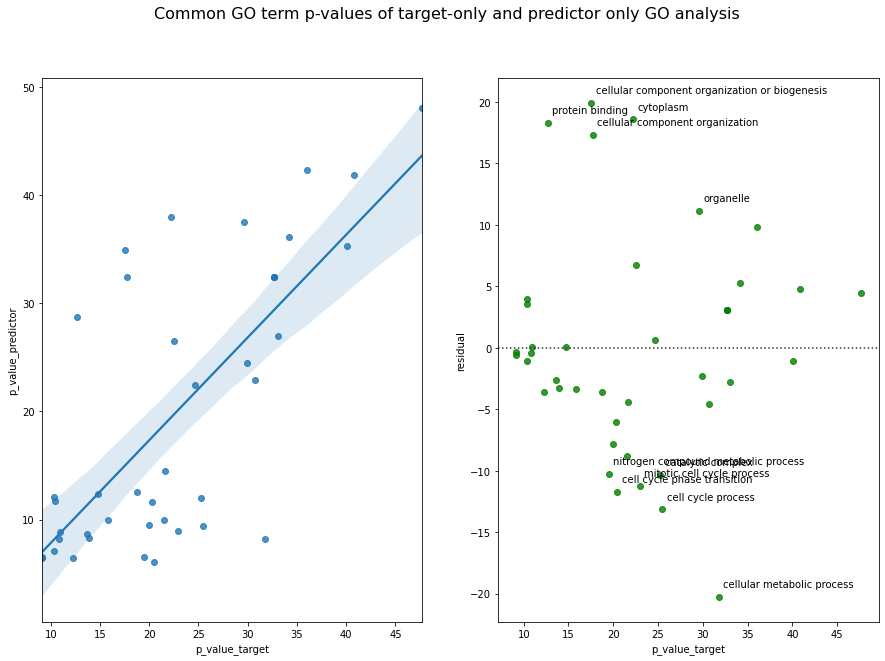

In [172]:
###target and predictor only-- log10 p-vals of common terms
df_target_top_common = df_target_top[df_target_top['term_name']\
            .isin(common_termname_target_pre)][['term_id','term_name','p_value','intersection_size']]\
            .set_index('term_id').add_suffix('_target')
df_predictor_top_common = df_predictor_top[df_predictor_top['term_name']\
            .isin(common_termname_target_pre)][['term_id','term_name','p_value','intersection_size']]\
            .set_index('term_id').add_suffix('_predictor')
df_combine = pd.concat([df_target_top_common,df_predictor_top_common],axis = 1)

# Log10 transformation
df_combine['p_value_target'] = -np.log10(df_combine['p_value_target'])
df_combine['p_value_predictor'] = -np.log10(df_combine['p_value_predictor'])

# Plot scatter(regression plot) and residual plot
fig, axs = plt.subplots(1,2, figsize = (15,10))
axs[0] = sns.regplot(x='p_value_target', y='p_value_predictor',data =df_combine, ax = axs[0])
axs[1] = sns.residplot(x='p_value_target', y='p_value_predictor', data =df_combine, color="g", ax = axs[1])
axs[1].set_ylabel('residual')

# Get x, y position in residual plot for annotating -https://stackoverflow.com/questions/32213889/get-positions-of-points-in-pathcollection-created-by-scatter
text = df_combine['term_name_target'] # terms for annotation
offset = axs[1].collections[0]
offset.set_offset_position('data')
datapos = offset.get_offsets()

for i in range(len(datapos)):
    xval = datapos[i][0];yval = datapos[i][1]
    if yval > 10 or yval < -10:
        # Find the term corresponding to the position
        termname = df_combine[df_combine['p_value_target'] == xval]['term_name_target'].values[0]
        axs[1].annotate(termname, (xval+ 0.5, yval +0.8))


fig.suptitle('Common GO term p-values of target-only and predictor only GO analysis', fontsize=16)

Most of the p-vals fall in diagnol. We are not really doing a regression here, but visualizing the residuals allow us to see how the true value of predictor/target only deviates from their 'linear regressed' expectation. Therefore I chose an arbitrary threshole of +-10. 

For common terms between target and predictor only, the terms that shift the ranking towards the higher end (observed -log10p > predicted -log10p , observed p < predicted p )are organization or biogenesis terms， and the one shift to a lower end a cell cycle and metabolic terms.

***Next, we send the common terms, target specific terms and All gene specific terms for Revigo analysis to identify the most redundant, general terms in each group***

In [163]:
len(common_termid_predonly) #64 overlapped terms in top100

64

In [168]:
# ### Specific term name
# target_only_term_name = df_target_top[~df_target_top['term_name'].isin(common_termname)]['term_name']
# all_only_term_name = df_all_top[~df_all_top['term_name'].isin(common_termname)]['term_name']
# target_only_term_id = df_target_top[~df_target_top['term_id'].isin(common_termid)]['term_id']
# all_only_term_id = df_all_top[~df_all_top['term_id'].isin(common_termid)]['term_id']

predict_only_term_id = df_predictor_top[~df_predictor_top['term_id'].isin(common_termid_target_pre)]['term_id']
target_only_term_id = df_target_top[~df_target_top['term_id'].isin(common_termid_target_pre)]['term_id']

Below are the code for generating term lists as input in the website

In [169]:
# Target and predictor only
for idx in common_termid_target_pre: #print common id
    print(idx)

GO:0031981
GO:0051301
GO:0043232
GO:0007049
GO:0070013
GO:0022402
GO:0005634
GO:0005737
GO:1903047
GO:1901564
GO:0043231
GO:0044770
GO:0044267
GO:0071840
GO:0005654
GO:0032991
GO:0033554
GO:0000278
GO:1902494
GO:0043229
GO:0006807
GO:0140535
GO:1901265
GO:0016043
GO:0140513
GO:0005829
GO:0043233
GO:0019538
GO:0005515
GO:0016032
GO:0043933
GO:0005622
GO:0000166
GO:0043226
GO:0044237
GO:0022607
GO:0043227
GO:0044085
GO:0043228
GO:0031974
GO:0006996


In [170]:
for idx in predict_only_term_id: #print common id
    print(idx)

GO:0051641
GO:0008104
GO:0005743
GO:0033036
GO:0070161
GO:0005739
GO:0005925
GO:0030055
GO:0098798
GO:0005740
GO:0048522
GO:0031967
GO:0031975
GO:0019866
GO:0031966
GO:0070727
GO:1990904
GO:0034613
GO:0046907
GO:0043624
GO:0035639
GO:0035556
GO:0051179
GO:0044391
GO:0032543
GO:0017076
GO:0032555
GO:0140053
GO:0032984
GO:0048518
GO:0005488
GO:0032553
GO:0005840
GO:0045184
GO:0005759
GO:0044093
GO:0051649
GO:0033043
GO:0009057
GO:0022411
GO:0044877
GO:0031090
GO:0019899
GO:0043168
GO:0044265
GO:0043604
GO:0007005
GO:0071705
GO:0070126
GO:0050790
GO:0007010
GO:0006415
GO:0006974
GO:0010604
GO:0015935
GO:0010638
GO:0015031
GO:0051668
GO:0006412


In [164]:
for idx in target_only_term_id: #print common id
    print(idx)

GO:0008152
GO:1901576
GO:0009058
GO:0044238
GO:0006139
GO:0044249
GO:0046483
GO:1901360
GO:0051726
GO:0010564
GO:0034641
GO:0006725
GO:0003824
GO:0071704
GO:0044271
GO:0044772
GO:1901362
GO:0044260
GO:0006793
GO:0006796
GO:0051276
GO:1990234
GO:0034654
GO:0018130
GO:0080090
GO:0019438
GO:2000142
GO:1901987
GO:0019222
GO:0055086
GO:0031323
GO:0060260
GO:0010033
GO:0016740
GO:0009165
GO:0140014
GO:0009719
GO:1901293
GO:0090304
GO:0009628
GO:0043170
GO:0019693
GO:0034645
GO:0009117
GO:0031325
GO:0036211
GO:0006464
GO:0065003
GO:0090407
GO:0046390
GO:0009059
GO:0006352
GO:0006753
GO:0051246
GO:0051171
GO:0006367
GO:0009893
GO:0000819
GO:0019637
